In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import soundfile as sf
import librosa

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#from pydub import AudioSegment
#from pyannote.audio.utils.signal import Binarize, Peak
#from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline, Timeline

#Specify path to codec exe used by pydub
#AudioSegment.converter='C:\\Users\\MrBrito\\Documents\\ffmpeg\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\bin\\ffmpeg.exe'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def plot_2Ddata(X2d, dimreduc, samptype, colors):
    fig, ax = plt.subplots(1, figsize=(11,9))
    #for x, y, w, t in zip(X2d.dim0, X2d.dim1, X2d.first_sample, X2d.index):
    
    if 'paralysis' in samptype:
        for x, y, t in zip(X2d.dim0, X2d.dim1, X2d['part'].str.slice(0,2).to_numpy(dtype = 'int32')):
        #    #plt.text(x, y, w, color=colors[t-1], fontsize=10)
            plt.text(x, y, str(t), color=colors[t-1], fontsize=10)
        plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
        #sns.scatterplot(X2d.dim0, X2d.dim1, hue=X2d['part'].str.slice(0,2), palette=colors, alpha = 0.6, s=10)

    else:
        for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.part):
            #plt.text(x, y, w, color=colors[t-1], fontsize=10)
            plt.text(x, y, str(t), color=colors[t-1], fontsize=10)
        plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
    if dimreduc == 'tSNE':
        plt.title("Plot of participant using tSNE, perplexity=" + str(per) + ", with metric=" + met + ", for " + samptype)
    elif dimreduc == 'UMAP':
        plt.title("Plot of participant using UMAP for " + samptype)
    plt.show()

def gen_color_code(X2d, name):
    colors = sns.color_palette("Paired", len(X2d['part'].unique())+1)
    #colors[13:]=sns.color_palette("hls")
    #colors[10] = (0,0,0)
    cmap = {}
    #[cmap.update({z:colors[z]}) for z in np.array(X2d.part.unique())]
    [cmap.update({z:colors[z]}) for z in np.arange(X2d['part'].unique().shape[0])]
    #.str.slice(0,2).to_numpy(dtype = 'int32')
    #X2d['c_clust'] = X2d.clusterSC.map(cmap)
    
    if 'paralysis' in name:
        X2d['c_part'] = [colors[z-1] for z in X2d['part'].str.slice(0,2).to_numpy(dtype = 'int32')]
    else:
        X2d['c_part'] = [colors[z-1] for z in X2d['part'].str.slice(0,2)]
    
    return X2d, colors 


def get_cluster_data(x, datasetname, factor,  umap_metric, resample=True, plot=True):
    #hellos2D_tsne = run_tSNE(hdown.drop('part', axis=1), perplexity = 30, metric = "euclidean")
    #sent2D_tsne = run_tSNE(sdown.drop('part', axis=1), perplexity = (len(sentdown.index)//10), metric="euclidean")
      
    if resample:
        xdown = resample_data(x, factor)
    else:
        xdown = x
   
    #run UMAP on xdown
    x2d, centers, center_labels = run_umap(X=xdown.drop('part',axis=1), y=xdown['part'], method = 'unsupervised', plot=False, metric=umap_metric)
    dimreduc = 'UMAP'
    #x2d['part'] = xdown['part'].str.slice(0,2).to_numpy(dtype = 'int32')
    x2d = x2d.dropna(inplace=False)
    x2d['part'] = xdown['part'].to_numpy()
    x2d, colors = gen_color_code(x2d, datasetname)
    
    if plot:
        plot_2Ddata(x2d, dimreduc, datasetname, colors)
    
    return {datasetname:{'x2d': x2d, 'centers':centers, 'center_labels':center_labels, 'colors': colors, 'data_resamp': xdown}}
    #return {datasetname:{'data_2D': x2d, 'centers':centers, 'center_labels':center_labels, 'data_resamp': xdown}}


In [14]:
def plot_norm_heatmap(dist_matrix, samptype):    
    #takes in normalized data and plots it
    
    # Generate a mask for the upper triangle for each
    mask = np.triu(np.ones_like(dist_matrix, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    ax.xaxis.set_ticks_position("top")

    # Generate a custom diverging colormap
    hmapcol = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dist_matrix, mask=mask, vmin=-1.0, vmax=1.0, cmap=hmapcol, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title("Distances between centroids of participants, for" + samptype, y = 1.08,fontsize=12)

#fig, ax = plt.subplots(1, figsize=(10,8))
#for x, y, t, g in zip(X2d.dim0, X2d.dim1, X2d.index, X2d.gcol):
#    plt.text(x, y, str(t), color=g, fontsize=10)
#plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
#plt.title("Plot of participant by perceived gender" + str(seedno))
#plt.show()




In [3]:
one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models


In [ ]:
[ee.pyannote_extract_directory(model,down_sampled_dir,embedding_dir,'020322_embeddings_testreadings', save=True) for model in emb_models]

In [4]:
#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020322")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb_down = {model:ee.resample_data(emb,5) for model, emb in all_embs.items()}


In [ ]:


#emb_tsne = {model:dr.run_tsne(ed) for model, ed in emb_down.items()}

#emb_umap = {model:dr.run_umap(ed) for model, ed in emb_down.items()}



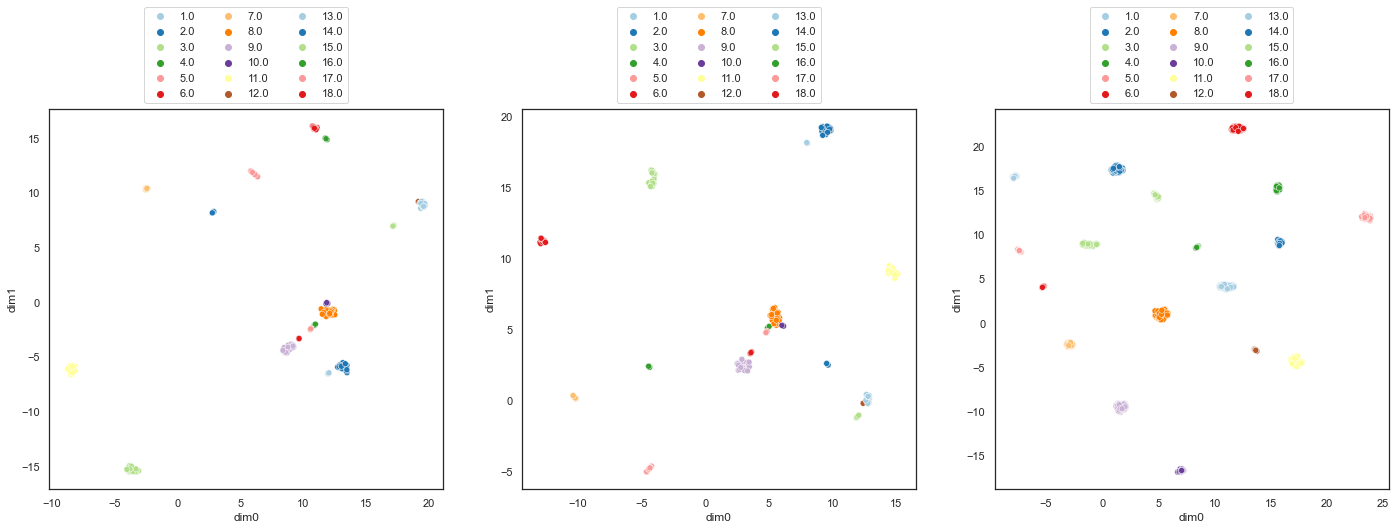

In [5]:
sns.set_theme(style="white")

#plot raw points
fig, ax = plt.subplots(ncols=3, figsize=(24,7))
#[sns.scatterplot(x=emb_umap[model].dim0, y=emb_umap[model].dim1, ax=ax[emb_models.index(model)]) for model in emb_models]

#plot raw points color coded by participant
#fig, ax = plt.subplots(1, figsize=(8,7))
#[babycol = sns.color_palette("Paired", len(emb_umap[model].part.unique()))for model in emb_models]
#babycol[12:]=sns.color_palette("hls", 6)
#babycol[10]=(0.3,0.3,0.3)
#babycol[13]=(0.5,0.5,0.5)
[sns.scatterplot(x=emb_umap[model].dim0, y=emb_umap[model].dim1, palette="Paired", hue=emb_umap[model].part_id, ax=ax[emb_models.index(model)]) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=3)for model in emb_models]

In [8]:
#haus_tsne = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_tsne.items()}

#haus_umap = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_umap.items()}

#haus_tsne = {model: haus.where(np.triu(np.ones(haus.shape), k=1).astype(np.bool)) for model, haus in haus_tsne.items()}
#haus_tsne_flat = {model: haus.stack().reset_index() for model, haus in haus_tsne.items()}

(array([ 5.,  4.,  9.,  9.,  7.,  9.,  3., 12.,  6.,  6., 14.,  7., 18.,
         5., 10.,  9.,  2.,  2.,  7.,  5.,  2.,  1.,  0.,  0.,  1.]),
 array([0.04147001, 0.07981121, 0.11815241, 0.15649361, 0.19483481,
        0.23317601, 0.27151721, 0.30985841, 0.34819961, 0.38654081,
        0.42488201, 0.46322321, 0.50156441, 0.53990561, 0.57824681,
        0.616588  , 0.6549292 , 0.6932704 , 0.7316116 , 0.7699528 ,
        0.808294  , 0.8466352 , 0.8849764 , 0.9233176 , 0.9616588 ,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x7f87ab566610>])

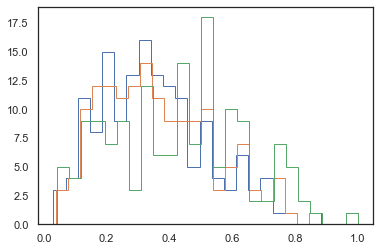

In [11]:
#fig, ax = plt.subplots()
#haus_tsne_flat[emb_models[0]]
#bins=25
#plt.hist(haus_tsne_flat[emb_models[0]].iloc[:,2],bins,histtype='step')
#plt.hist(haus_tsne_flat[emb_models[1]].iloc[:,2],bins,histtype='step')
#plt.hist(haus_tsne_flat[emb_models[2]].iloc[:,2],bins,histtype='step')

In [5]:
plst = np.arange(18)+1 

#loo is leave one out. Creates a dictionary: {participant_removed:{embedding model:embeddings}} for each participant and embedding model
loo = {'rm' + str(p):
        {mod:
         ed[ed.part_id!=plst[p-1]].reset_index(drop=True) 
         for mod, ed in emb_down.items()
        } 
        for p in plst
       }

In [6]:
#Creates a dictionary: {participant_removed:{embedding model:two-dimension embeddings}} for each participant and embedding model with either tnse or umap
loo_tsne = {rm:
            {mod:dr.run_tsne(ed) 
             for mod, ed in ed_all.items()
            } 
            for rm, ed_all in loo.items()
           }

loo_umap = {rm:
            {mod:dr.run_umap(ed) 
             for mod, ed in ed_all.items()
            } 
            for rm, ed_all in loo.items()
           }
            

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
#Creates a dictionary: {participant_removed:{embedding model:hausdorf distance}} for each participant and embedding model
#with hausdorff distances between each participant's two-dimension point-cloud, on either the tsne or umap
loo_haus_tsne = {rm:
             {mod:dm.hausdorff_distances(e2d) 
              for mod, e2d in e2d_all.items()
             } 
             for rm, e2d_all in loo_tsne.items()
            }

loo_haus_umap = {rm:
             {mod:dm.hausdorff_distances(e2d) 
              for mod, e2d in ed_all.items()
             } 
             for rm, ed_all in loo_umap.items()
            }

#flatten the hausdorf distances for plotting and only get column 2 which has the distances (0 and 1 have the pairs of participants)
loo_haus_tsne_flat = {rm:
                 {mod: haus.stack().reset_index().iloc[:,2]
                  for mod, haus in haus_all.items()
                 } 
                 for rm, haus_all in loo_haus_tsne.items()
                }

Processing row 3, col 13


<function matplotlib.pyplot.show(close=None, block=None)>

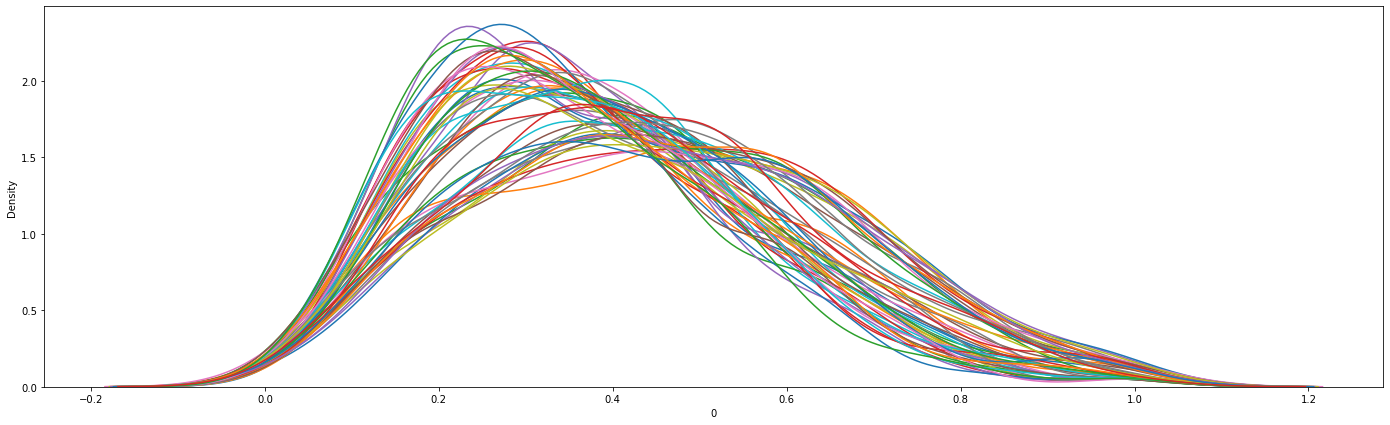

In [83]:
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

#[plt.hist(dist[dist>0], bins) for haus in loo_haus_tsne_flat.values() for dist in haus.values()]
[sns.distplot(dist[dist>0],hist=False) for haus in loo_haus_tsne_flat.values() for dist in haus.values()]

plt.show

In [80]:
a = loo_haus_tsne_flat['rm1']['emb'][loo_haus_tsne_flat['rm1']['emb']>0]
b = loo_haus_tsne_flat['rm2']['emb'][loo_haus_tsne_flat['rm2']['emb']>0]

stats.ttest_ind(a,b, equal_var=False)

Ttest_indResult(statistic=2.0028201331113067, pvalue=0.045702285155521084)

In [ ]:
#load already extracted embeddings as dictionary of dataframes #all_data = {os.path.splitext(f)[0]:pd.read_csv(os.path.join(loc, f), index_col=0) for f in os.listdir(loc)}

#baby = all_data['sentences']

#embs_resample = resample_data(baby, 5)#.dropna(inplace = False)

#X2d['first_sample']=sid #gmap = {1:'m', 2:'f', 3:'f', 4:'f', 5:'m', 6:'f', 7:'m', 8:'f', 9:'f', 10:'f', 11:'f', 12:'m', 13:'f', 14:'f', 15:'m', 16:'f', 18:'f'} #X2d['gender'] = X2d.index.map(gmap) #gendercolor = [(0.41568627450980394, 0.23921568627450981, 0.6039215686274509), (0.2, 0.6274509803921569, 0.17254901960784313)] #gcmap = {'m':gendercolor[0], 'f': gendercolor[1]} #X2d['gcol'] = X2d.gender.map(gcmap) #X2d['clusterSC'] = SpectralClustering(n_components=np.size(sid)).fit_predict(X2d)

In [21]:
# k means
#X2d=out['paralysis']['x2d']
X2d = embs_umap
kmeans = KMeans(n_clusters=len(X2d.part.unique()))
X2d['cluster'] = kmeans.fit_predict(X2d[['dim0', 'dim1']])

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to tSNE cluster pd
xmap = {}
ymap = {}
[xmap.update({z:cen_x[z]}) for z in np.arange(len(cen_x))]
[ymap.update({z:cen_y[z]}) for z in np.arange(len(cen_y))]
X2d['cen_x'] = X2d.cluster.map(xmap)
X2d['cen_y'] = X2d.cluster.map(ymap)

#define and map colors
#based on cluster
colors = sns.color_palette("Paired", len(X2d.part.unique())+2)
cmap = {}
[cmap.update({z:colors[z]}) for z in np.arange(len(cen_x))]
X2d['c_clust'] = X2d.cluster.map(cmap)
#X2d['c_part'] = [colors[z] for z in X2d.part.unique()]

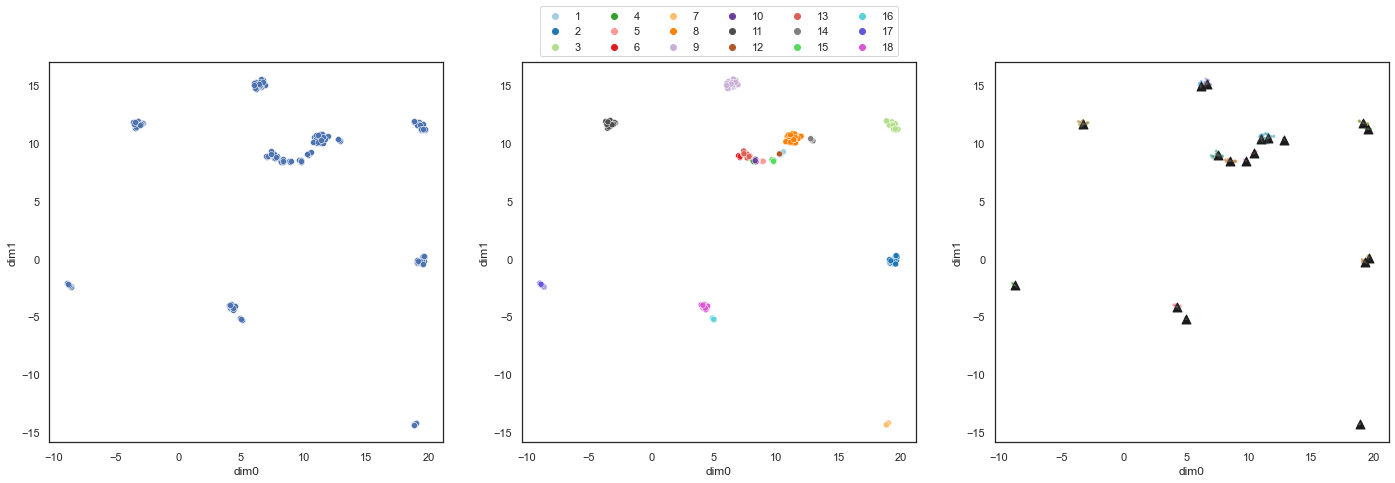

In [22]:
sns.set_theme(style="white")

#plot raw points
fig, ax = plt.subplots(ncols=3, figsize=(24,7))
sns.scatterplot(x=embs_umap.dim0, y=embs_umap.dim1, ax=ax[0])

#plot raw points color coded by participant
#fig, ax = plt.subplots(1, figsize=(8,7))
babycol = sns.color_palette("Paired", len(embs_umap.part.unique()))
babycol[12:]=sns.color_palette("hls", 6)
babycol[10]=(0.3,0.3,0.3)
babycol[13]=(0.5,0.5,0.5)
sns.scatterplot(x=embs_umap.dim0, y=embs_umap.dim1, hue=embs_umap.part, palette=babycol, ax=ax[1])
legend1 = ax[1].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)

#compare to kmeans clustering
#fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x=X2d.dim0, y=X2d.dim1, hue=X2d.c_clust, alpha = 0.6, s=10, ax=ax[2])
legend2 = ax[2].legend()
legend2.remove()

#plot distances
for idx, val in X2d.iterrows():
    x = [val.dim0, val.cen_x,]
    y = [val.dim1, val.cen_y]
    #plt.plot(x, y, c=val.c_clust, alpha=0.2)
    plt.plot(x, y, c='0.4', alpha=0.2)

#plot centroids
plt.scatter(cen_x, cen_y, marker='^', c='0.1', s=80)
#plt.title("Plot of participant using UMAP for " + samptype + "with kmeans centroids")
plt.show()

In [17]:
toRemove=12

train_data = embs_resample[embs_resample.part != toRemove].drop('part', axis=1)
train_labels = embs_resample['part'][embs_resample.part != toRemove]

test_data = embs_resample[embs_resample.part == toRemove].drop('part', axis=1)
test_labels = embs_resample['part'][embs_resample.part == toRemove]

mapper = umap.UMAP(n_neighbors=10).fit(train_data, train_labels.to_numpy())
test_embedding = mapper.transform(test_data)

/Users/rahulbrito/opt/miniconda3/envs/infantvoice/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Text(0.5, 0.95, 'Data after removing participant 12')

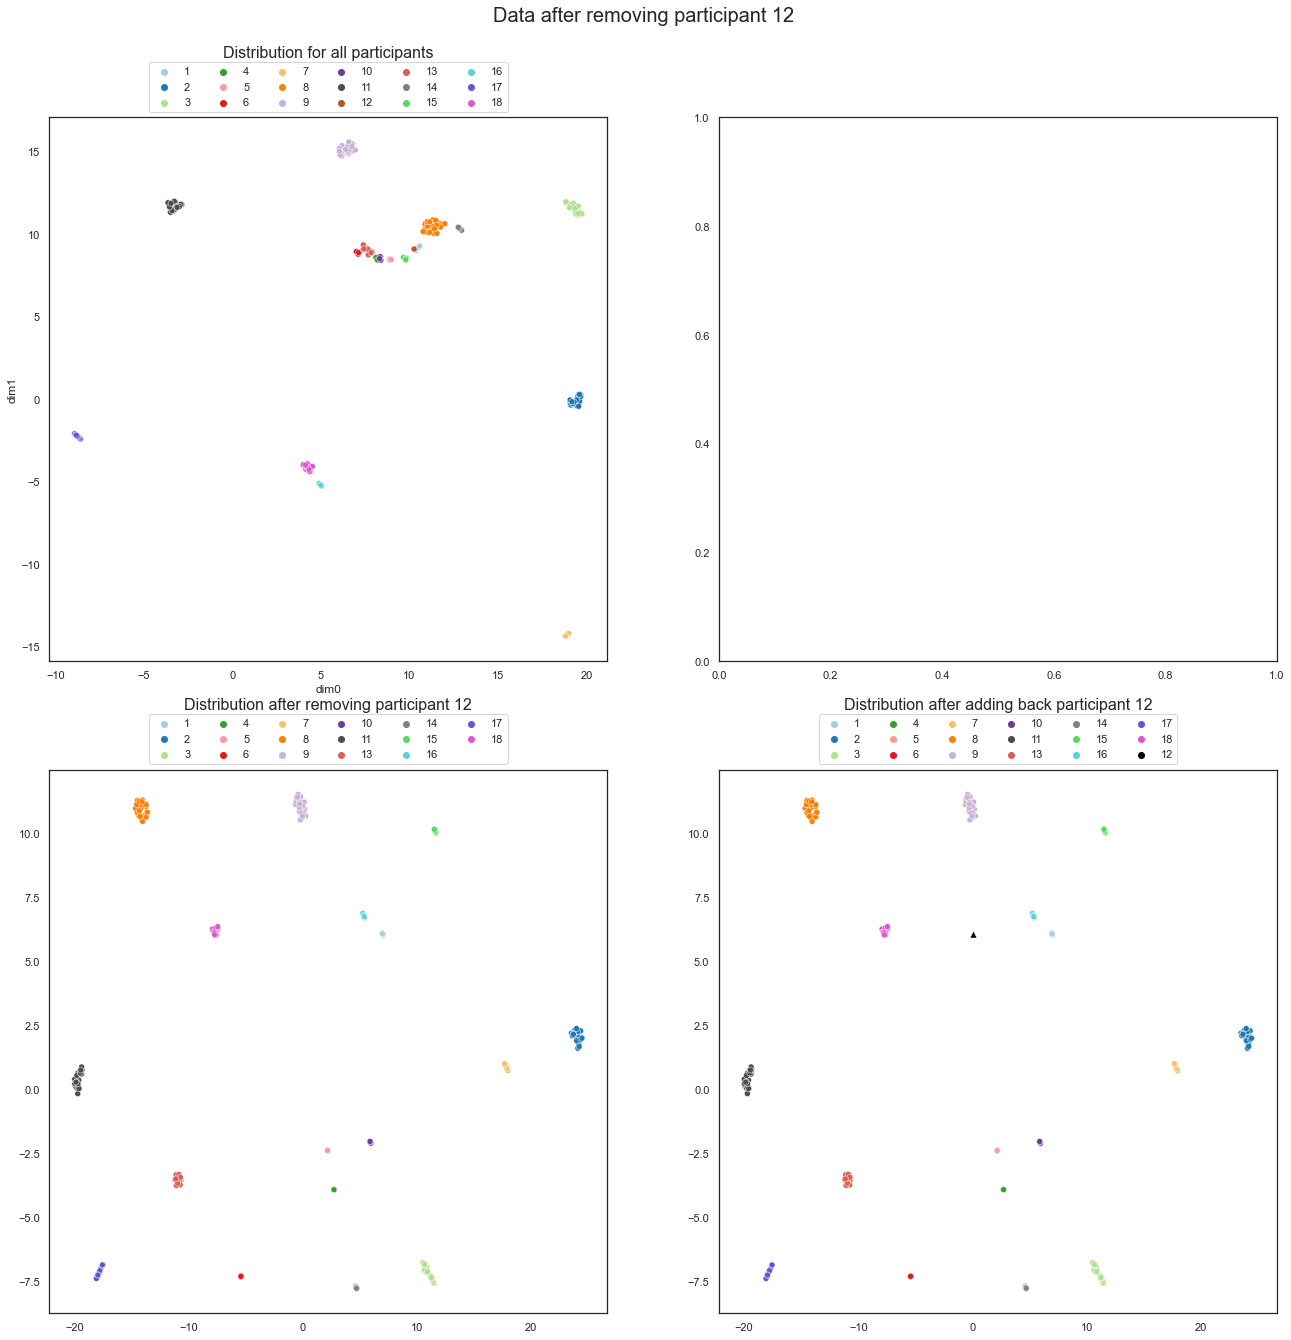

In [18]:
babycol = sns.color_palette("Paired", len(embs_umap.part.unique()))
babycol[12:]=sns.color_palette("hls", 6)
babycol[10]=(0.3,0.3,0.3)
babycol[13]=(0.5,0.5,0.5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
sns.scatterplot(x=embs_umap.dim0, y=embs_umap.dim1, hue=embs_umap.part, palette=babycol, ax=ax[0,0])
legend1 = ax[0,0].legend(loc="lower center", bbox_to_anchor=(0.5, 1),  ncol=len(embs_umap.part.unique())//3)
ax[0,0].set_title("Distribution for all participants", y=1.1, fontsize=16)

babycol.pop(toRemove-1)
sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,0])
legend1 = ax[1,0].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,0].set_title("Distribution after removing participant " + str(toRemove), y=1.1, fontsize=16)

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,1])
sns.scatterplot(x=test_embedding[:,0], y=test_embedding[:,1], marker='^', hue=test_labels, palette={toRemove:'black'}, s=50, ax=ax[1,1])
legend1 = ax[1,1].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,1].set_title("Distribution after adding back participant " + str(toRemove), y=1.1, fontsize=16)

fig.suptitle("Data after removing participant " + str(toRemove), fontsize=20, y=.95)

Text(0.5, 0.95, 'Data after removing participant 12')

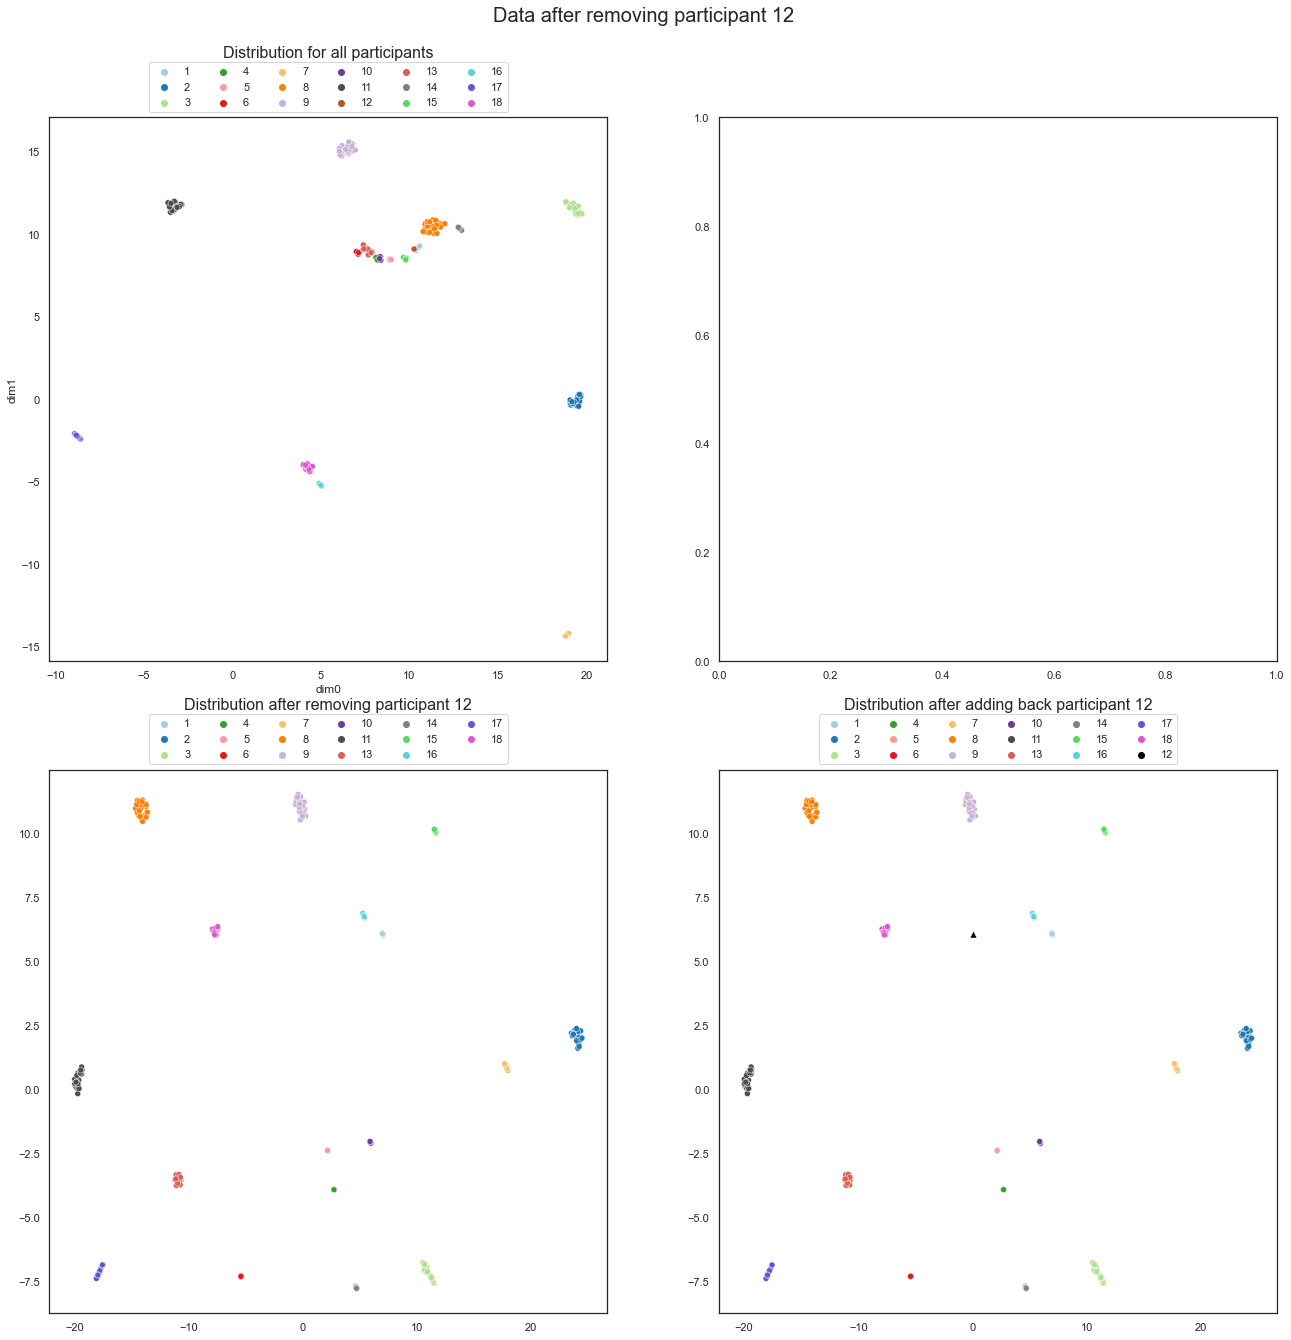

In [19]:
babycol = sns.color_palette("Paired", len(embs_umap.part.unique()))
babycol[12:]=sns.color_palette("hls", 6)
babycol[10]=(0.3,0.3,0.3)
babycol[13]=(0.5,0.5,0.5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
sns.scatterplot(x=embs_umap.dim0, y=embs_umap.dim1, hue=embs_umap.part, palette=babycol, ax=ax[0,0])
legend1 = ax[0,0].legend(loc="lower center", bbox_to_anchor=(0.5, 1),  ncol=len(embs_umap.part.unique())//3)
ax[0,0].set_title("Distribution for all participants", y=1.1, fontsize=16)

babycol.pop(toRemove-1)
sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,0])
legend1 = ax[1,0].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,0].set_title("Distribution after removing participant " + str(toRemove), y=1.1, fontsize=16)

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,1])
sns.scatterplot(x=test_embedding[:,0], y=test_embedding[:,1], marker='^', hue=test_labels, palette={toRemove:'black'}, s=50, ax=ax[1,1])
legend1 = ax[1,1].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,1].set_title("Distribution after adding back participant " + str(toRemove), y=1.1, fontsize=16)

fig.suptitle("Data after removing participant " + str(toRemove), fontsize=20, y=.95)

Text(0.5, 0.95, 'Data after removing participant 12')

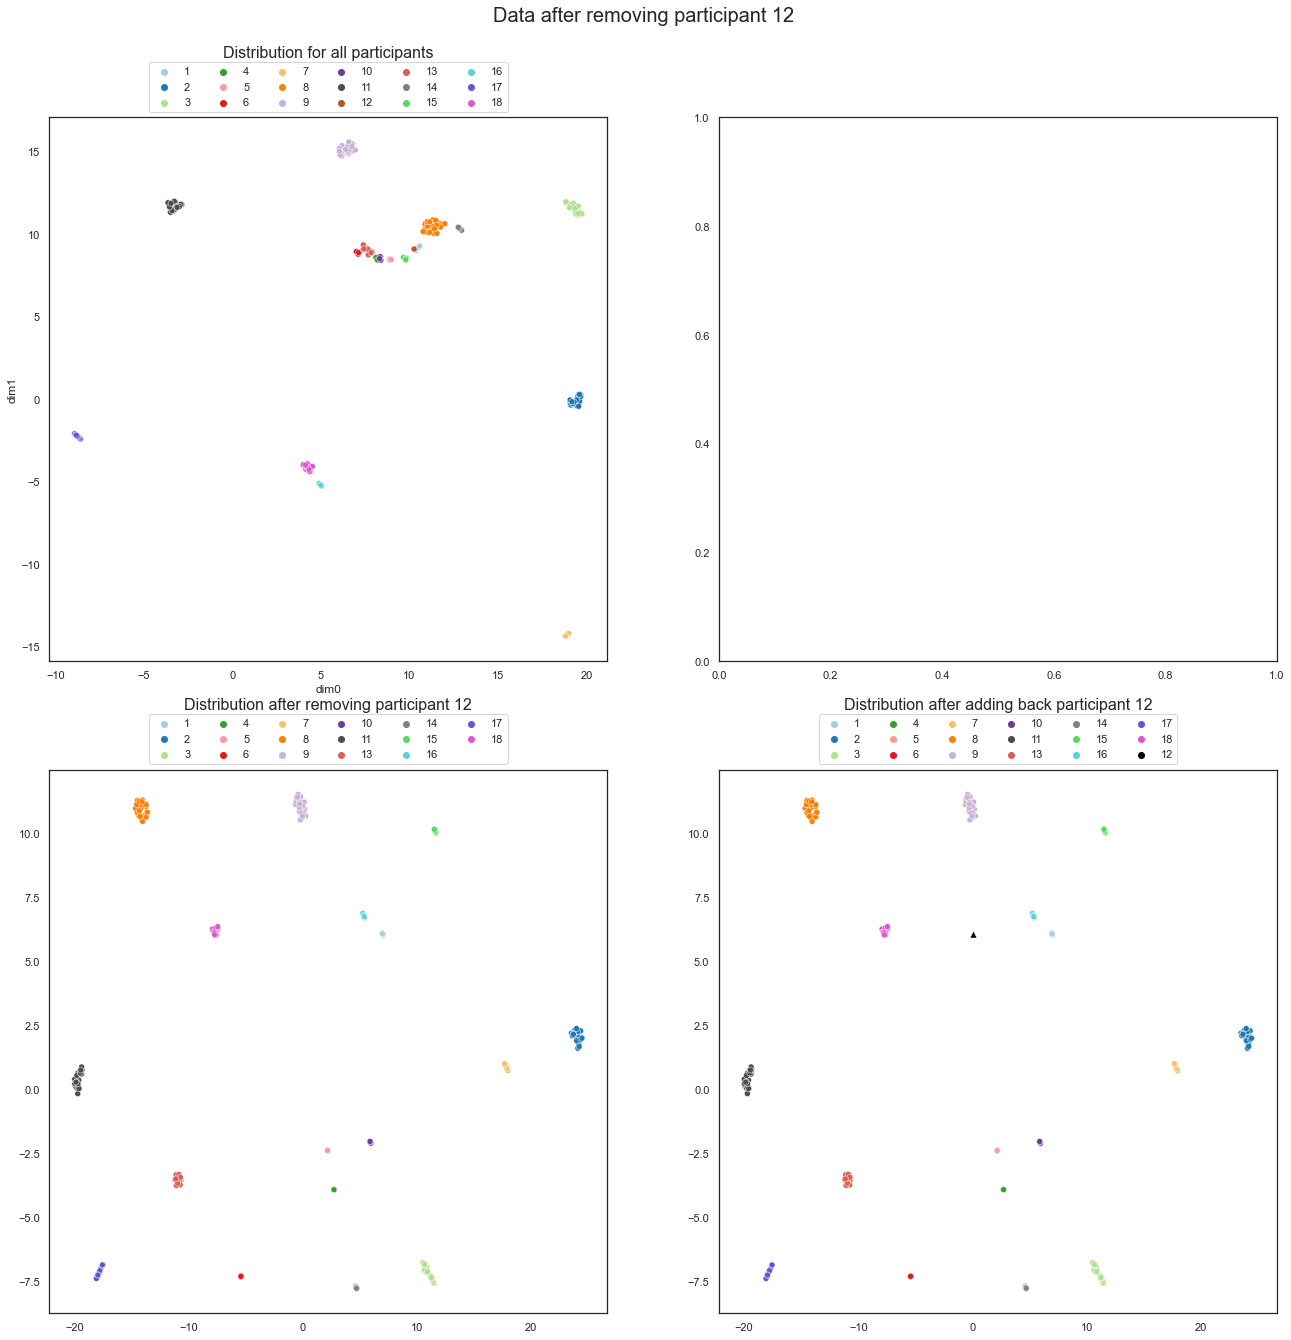

In [20]:
babycol = sns.color_palette("Paired", len(embs_umap.part.unique()))
babycol[12:]=sns.color_palette("hls", 6)
babycol[10]=(0.3,0.3,0.3)
babycol[13]=(0.5,0.5,0.5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
sns.scatterplot(x=embs_umap.dim0, y=embs_umap.dim1, hue=embs_umap.part, palette=babycol, ax=ax[0,0])
legend1 = ax[0,0].legend(loc="lower center", bbox_to_anchor=(0.5, 1),  ncol=len(embs_umap.part.unique())//3)
ax[0,0].set_title("Distribution for all participants", y=1.1, fontsize=16)

babycol.pop(toRemove-1)
sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,0])
legend1 = ax[1,0].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,0].set_title("Distribution after removing participant " + str(toRemove), y=1.1, fontsize=16)

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,1])
sns.scatterplot(x=test_embedding[:,0], y=test_embedding[:,1], marker='^', hue=test_labels, palette={toRemove:'black'}, s=50, ax=ax[1,1])
legend1 = ax[1,1].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,1].set_title("Distribution after adding back participant " + str(toRemove), y=1.1, fontsize=16)

fig.suptitle("Data after removing participant " + str(toRemove), fontsize=20, y=.95)

Text(0.5, 0.95, 'Data after removing participant 15')

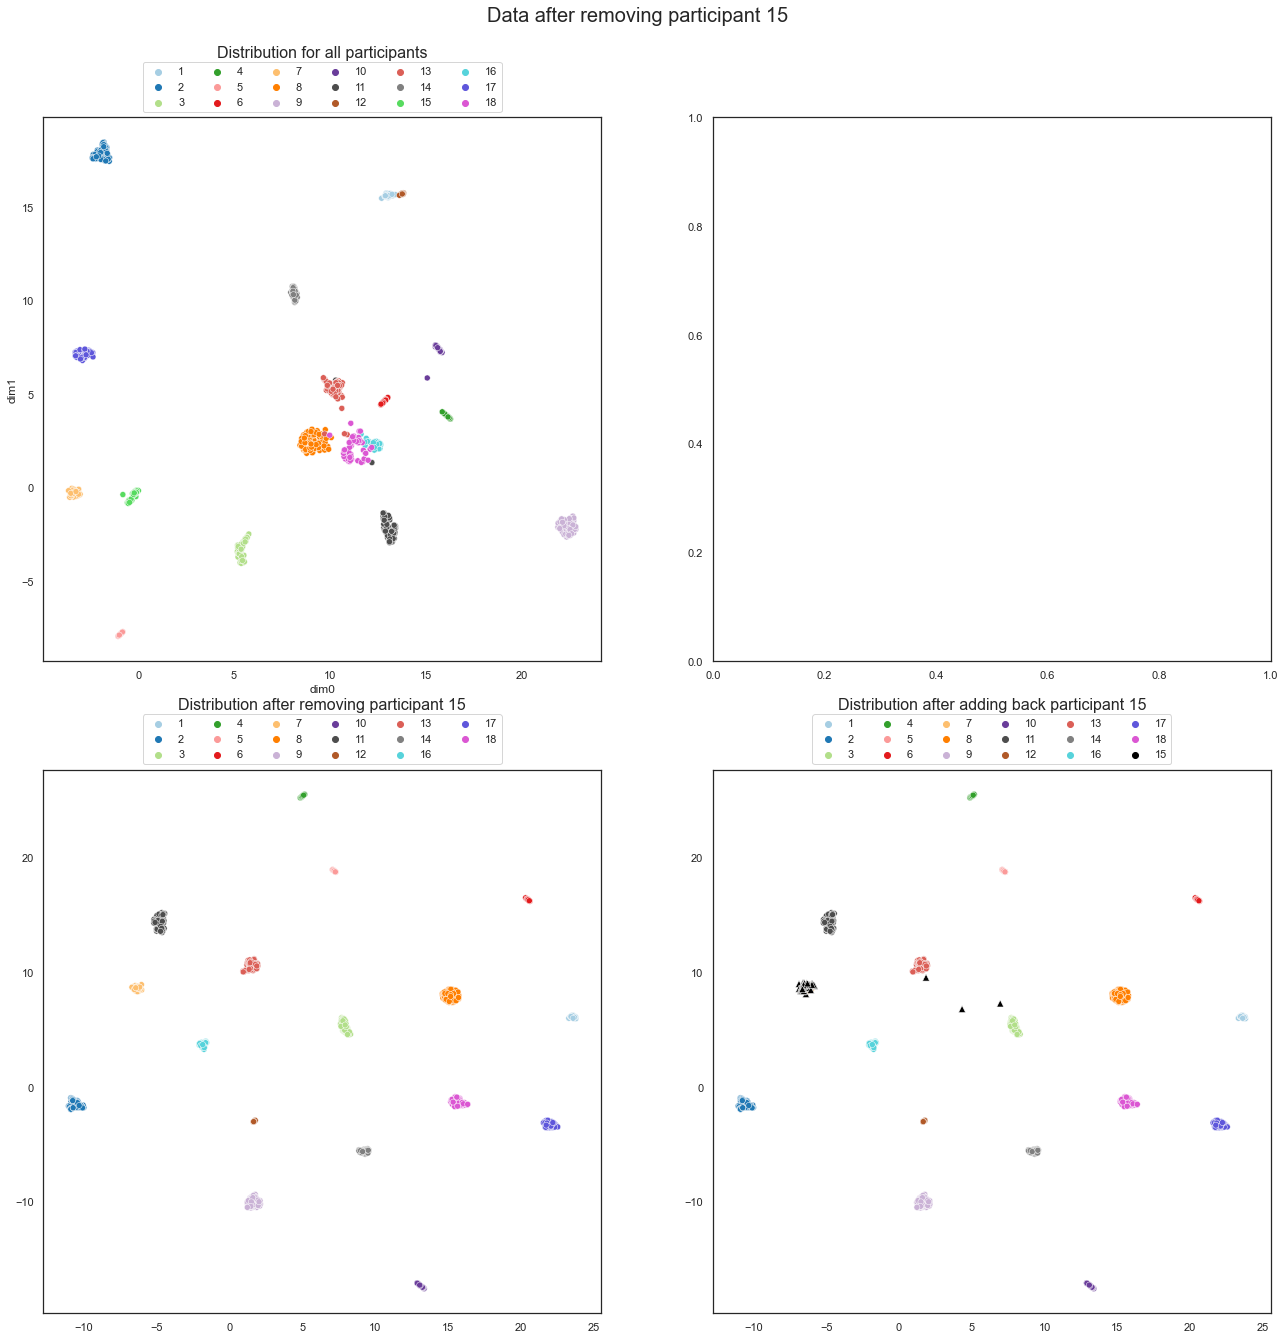

In [250]:
babycol = sns.color_palette("Paired", len(embs_umap.part.unique()))
babycol[12:]=sns.color_palette("hls", 6)
babycol[10]=(0.3,0.3,0.3)
babycol[13]=(0.5,0.5,0.5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
sns.scatterplot(x=embs_umap.dim0, y=embs_umap.dim1, hue=embs_umap.part, palette=babycol, ax=ax[0,0])
legend1 = ax[0,0].legend(loc="lower center", bbox_to_anchor=(0.5, 1),  ncol=len(embs_umap.part.unique())//3)
ax[0,0].set_title("Distribution for all participants", y=1.1, fontsize=16)

babycol.pop(toRemove-1)
sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,0])
legend1 = ax[1,0].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,0].set_title("Distribution after removing participant " + str(toRemove), y=1.1, fontsize=16)

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=train_labels, palette=babycol, ax=ax[1,1])
sns.scatterplot(x=test_embedding[:,0], y=test_embedding[:,1], marker='^', hue=test_labels, palette={toRemove:'black'}, s=50, ax=ax[1,1])
legend1 = ax[1,1].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=len(embs_umap.part.unique())//3)
ax[1,1].set_title("Distribution after adding back participant " + str(toRemove), y=1.1, fontsize=16)

fig.suptitle("Data after removing participant " + str(toRemove), fontsize=20, y=.95)

In [ ]:
factors = {'hellos': 3, 'sentences': 5, 'paralysis':5, 'paralysis_emb':3}
#for dataset in all_data:
#    x2d, x_centers, x_labels, x_colors = get_cluster_data(all_data[dataset], dataset, factors[dataset])

cluster_data = [get_cluster_data(all_data[dataset], dataset, factors[dataset], plot=True, umap_metric='euclidean') for dataset in all_data]

In [ ]:
io = 'C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\vowel_identity\\VFPsex.csv'

demo = pd.read_csv(io)

In [ ]:
#all_data['paralysis']['cond']=all_data['paralysis'].part.str.slice(2)
#data = all_data['paralysis']

all_data['paralysis']['cond']=all_data['paralysis'].part.str.slice(2)
data = all_data['paralysis']

#all_data['paralysis_emb']['cond']=all_data['paralysis_emb'].part.str.slice(2)
#data = all_data['paralysis_emb']

#out = get_cluster_data(data[data.cond=='n'], 'paralysis', 3, "euclidean", plot=False)
#out = get_cluster_data(data[data.sno!='S'], 'paralysis', 3, "euclidean", plot=True)
out = get_cluster_data(data[(data.sno!='S') & (data.cond=='n')], 'paralysis', 3, "euclidean", plot=True)
#out = get_cluster_data(data, 'paralysis', 3, "euclidean", plot=False)


#out = get_cluster_data(data[data.sno!='S'], 'paralysis_emb', 3, "euclidean", plot=True)

In [ ]:
X2d = out['paralysis']['x2d']
colors2D=out['paralysis']['colors']
#plot_2Ddata(X2d, 'UMAP', 'paralysis', sns.color_palette("Paired", len(X2d['part'].unique())))
plot_2Ddata(X2d, 'UMAP', 'paralysis', colors2D)
#plot_2Ddata(X2d[X2d.part.str.slice(-1)!='v'], 'UMAP', 'paralysis', colors2D)
#plot_2Ddata(X2d[(X2d.part.str.slice(-1)!='v') & (X2d.sex=='M')], 'UMAP', 'paralysis', colors2D)

#fig1, ax = plt.subplots(1, figsize=(10,8))
#clust_col = sns.color_palette("Paired", len(X2d.part.str.slice(0,2).unique()))
#sns.scatterplot(x=X2d.dim0, y=X2d.dim1, hue=X2d.part.str.slice(0,2), palette=clust_col)
#plt.legend([],[], frameon=False)

In [ ]:
scol = sns.color_palette("hls", 2)
smap = {'F': scol[0], 'M': scol[1]}

a=demo.set_index(demo.ID.str.slice(-2))['Sex']
b = a.to_dict()
X2d['sex']=X2d.part.str.slice(0,2).map(b)
X2d['sex_col']=X2d.sex.map(smap)

fig1, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x=X2d.dim0, y=X2d.dim1, hue=X2d.sex, palette=scol)
plt.title('Paralysis corpus UMAP colored by participant sex')

In [ ]:
acol = sns.color_palette("hls", len(demo.Age.unique()))
ages = np.sort(demo.Age.unique())
amap ={}
[amap.update({ages[z]: acol[z]}) for z in range(len(ages))]

a=demo.set_index(demo.ID.str.slice(-2))['Age']
b = a.to_dict()
X2d['age']=X2d.part.str.slice(0,2).map(b)
X2d['age_col']=X2d.age.map(amap)

fig1, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x=X2d.dim0, y=X2d.dim1, c=X2d.age_col)
plt.title('Paralysis corpus UMAP colored by participant age')


In [ ]:
colors=sns.color_palette("mako", 2)
cmap = {'n': colors[0], 'v': colors[1]}

df = out['paralysis']['x2d'].drop('c_part', axis=1)
df['cpart'] = [cmap[z] for z in df['part'].str.slice(2)]

fig, ax = plt.subplots(1, figsize=(8,6))
sns.scatterplot(x=df.dim0, y=df.dim1, hue=df.part.str.slice(-1), palette=colors)
plt.title('Paralysis corpus UMAP colored by n: normal or v: vocal fold paralysis')      
plt.show()

In [ ]:
which = 'sentences'
ind = 1
base = cluster_data[ind][which]['data_resamp']
cent = cluster_data[ind][which]['centers']
cent_lab=cluster_data[ind][which]['center_labels']
part_list = base.part.unique().astype('int32')
all_centers = []

for toRemove in part_list:
#for toRemove in np.arange(3)+1:
    clear_output(wait=True)
    print("Processing " + str(toRemove))
    X = base[base.part != toRemove].drop('part', axis=1)
    y = base['part'][base.part != toRemove]

    X_test = base[base.part == toRemove].drop('part', axis=1)
    y_test = base['part'][base.part == toRemove]
   
    reduced, test, reduced_centers, reduced_centers_labels = run_umap(X=X, y=y, method='metric_learning', metric='euclidean', X_test=X_test, y_test=y_test, plot=False)
    reduced['part'] = y.to_numpy(dtype = 'int32')
    test['part'] = y_test.to_numpy(dtype = 'int32')
    
    
    all_centers.append(np.concatenate((reduced_centers, reduced_centers_labels[:,None], np.full((reduced_centers.shape[0],1), toRemove)), axis=1))

all_centers = pd.DataFrame(np.vstack(all_centers), columns = ['dim0', 'dim1', 'part', 'removed']).dropna(inplace = False)
all_centers = all_centers.astype({'part':int, 'removed':int})

In [ ]:
group = all_centers.groupby('removed')
prof_sim = []

for name, features in group:
    #if name==18:
    #    full_dist = euclidean_distances(np.delete(cent, name-2, axis=0), np.delete(cent_lab,name-2,axis=0), np.delete(cent_lab,name-2,axis=0))
    #else:
    #    full_dist = euclidean_distances(np.delete(cent, name-1, axis=0), np.delete(cent_lab,name-1,axis=0), np.delete(cent_lab,name-1,axis=0))
    full_dist = euclidean_distances(np.delete(cent, name-1, axis=0), np.delete(cent_lab,name-1,axis=0), np.delete(cent_lab,name-1,axis=0))
    minus1_dist = euclidean_distances(features[['dim0','dim1']].to_numpy(dtype='float64'), features['part'].to_numpy(dtype='int32'),  features['part'].to_numpy(dtype='int32'))
    #full_norm = full_dist/full_dist.to_numpy().max()
    #minus1_norm = minus1_dist/minus1_dist.to_numpy().max()
    #prof_sim.append([np.mean(np.sqrt(np.sum((full_dist-minus1_dist) **2, axis=1))), name])
    prof_sim.append([np.mean(np.sqrt(np.sum((full_dist) **2, axis=1))), name])
    #prof_sim.append([np.mean(np.sqrt(np.sum((full_norm-minus1_norm) **2, axis=1))), name])
    #prof_sim.append([np.mean(np.sqrt(np.sum((full_norm-full_norm) **2, axis=1))), name])

prof_sim = pd.DataFrame(np.vstack(prof_sim), columns=['dist_prof_sim', 'when_removed'])

In [ ]:
fig1, ax = plt.subplots(1, figsize=(7,7))

for a, b, t in zip(reduced.dim0, reduced.dim1, reduced.part):
    plt.text(a, b, str(t), color=cluster_data[1][which]['colors'][t-1], fontsize=10)
plt.scatter(reduced.dim0, reduced.dim1, c='1', alpha = 0.6, s=10)
plt.show()

fig2, ax = plt.subplots(1, figsize=(7,7))
for a, b, t in zip(reduced.dim0, reduced.dim1, reduced.part):
    plt.text(a, b, str(t), color=cluster_data[1][which]['colors'][t-1], fontsize=10)
plt.scatter(reduced.dim0, reduced.dim1, c='1', alpha = 0.6, s=10)
for a, b, t in zip(test.dim0, test.dim1, test.part):
    plt.text(a, b, str(t), color=cluster_data[1][which]['colors'][t-1], fontsize=10)
plt.scatter(test.dim0, test.dim1, c='1', alpha = 0.6, s=10)
plt.show()


In [ ]:
#plot_haus_heatmap(haus_h, 'hellos')
#plot_haus_heatmap(haus_s, 'sentences')

#haus_all_norm = haus_all/haus_all.to_numpy().max()
#haus_less_norm = haus_less/haus_less.to_numpy().max()

euc_all_norm = euc_all/euc_all.to_numpy().max()
euc_less_norm = euc_less/euc_less.to_numpy().max()

#plot_norm_heatmap(euc_all_norm, 'all')
#plot_norm_heatmap(euc_less_norm, 'less')

plot_norm_heatmap(euc_all_norm-euc_less_norm, 'diff')

In [ ]:
comp = haus_all-haus_less
s = comp.unstack()
so = s.sort_values(kind="quicksort")
so = so[so!=0] #drop rows where samples have 0 distance (comparing the same sample)
so

In [ ]:
specclus = SpectralClustering(n_clusters=len(X2d.part.unique()))
X2d['cluster'] = specclus.fit_predict(X2d[['dim0', 'dim1']])


In [ ]:
#reducer=umap.UMAP()
#X2d =pd.DataFrame(reducer.fit_transform(Xdown.iloc[:, :-1]), columns = ['dim0', 'dim1'])
#X2d['part'] = Xdown['part'].to_numpy(dtype = 'int32')

#fig, ax = plt.subplots(1, figsize=(10,8))
#for x, y, w, t in zip(X2d.dim0, X2d.dim1, X2d.first_sample, X2d.index):
#for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.part):
    #plt.text(x, y, w, color=colors[t-1], fontsize=10)
#    plt.text(x, y, str(t), color=colors[t-1], fontsize=10)
#plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
#plt.title("Plot of participant using UMAP for " + samptype)
#plt.show()

# plot 
#fig, ax = plt.subplots()
#fig.set_figheight(7.5)
#fig.set_figwidth(7.5)
#plt.legend(y_true[:120], loc='center left', bbox_to_anchor=(1.0, 0.75))
#plt.scatter(*X_2dU.T, c=y_true)
#plt.scatter(*X_2dU[:n,:].T, c=y_true[:n])
